<a href="https://colab.research.google.com/github/WiggleCode/AAI-530-IoT-Application-Design-Final-Project/blob/main/RNN%20Model%20in%20progress%20Jeff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential

In [2]:
df_raw = pd.read_csv('IoTProcessed_Data.csv')

df_raw.head()

,date,tempreature,humidity,water_level,N,P,K,Fan_actuator_OFF,Fan_actuator_ON,Watering_plant_pump_OFF,Watering_plant_pump_ON,Water_pump_actuator_OFF,Water_pump_actuator_ON
0,2024-02-08 06:10:00,41,63,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
1,2024-02-08 06:15:00,41,59,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
2,2024-02-08 06:20:00,41,62,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
3,2024-02-08 06:05:00,40,60,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
4,2024-02-08 06:00:00,39,61,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0


In [3]:
df = df_raw.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37922 entries, 0 to 37921
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     37920 non-null  object 
 1   tempreature              37922 non-null  int64  
 2   humidity                 37922 non-null  int64  
 3   water_level              37922 non-null  int64  
 4   N                        37922 non-null  int64  
 5   P                        37922 non-null  int64  
 6   K                        37922 non-null  int64  
 7   Fan_actuator_OFF         37922 non-null  float64
 8   Fan_actuator_ON          37922 non-null  float64
 9   Watering_plant_pump_OFF  37922 non-null  float64
 10  Watering_plant_pump_ON   37922 non-null  float64
 11  Water_pump_actuator_OFF  37922 non-null  float64
 12  Water_pump_actuator_ON   37922 non-null  float64
dtypes: float64(6), int64(6), object(1)
memory usage: 3.8+ MB


In [27]:
# Creating a 'datetime' timeseries feature from object Dtype 'date'
# df['datetime'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Code format pulled from Dylan Scott-Dawkins
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37920 entries, 0 to 37919
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     37920 non-null  datetime64[ns]
 1   tempreature              37920 non-null  int64         
 2   humidity                 37920 non-null  int64         
 3   water_level              37920 non-null  int64         
 4   N                        37920 non-null  int64         
 5   P                        37920 non-null  int64         
 6   K                        37920 non-null  int64         
 7   Fan_actuator_OFF         37920 non-null  float64       
 8   Fan_actuator_ON          37920 non-null  float64       
 9   Watering_plant_pump_OFF  37920 non-null  float64       
 10  Watering_plant_pump_ON   37920 non-null  float64       
 11  Water_pump_actuator_OFF  37920 non-null  float64       
 12  Water_pump_actuator_ON   37920 n

In [28]:
df_grouped_month = df.groupby(df['month'])

df_grouped_month.value_counts()

month  date                 tempreature  humidity  water_level  N    P    K    Fan_actuator_OFF  Fan_actuator_ON  Watering_plant_pump_OFF  Watering_plant_pump_ON  Water_pump_actuator_OFF  Water_pump_actuator_ON  hour  day
1      2024-01-01 00:01:00  19           70        85           178  186  157  1.0               0.0              1.0                      0.0                     1.0                      0.0                     0     1      1
       2024-01-01 00:06:00  21           69        81           178  186  157  1.0               0.0              1.0                      0.0                     1.0                      0.0                     0     1      1
       2024-01-01 00:11:00  22           68        93           178  186  157  1.0               0.0              1.0                      0.0                     1.0                      0.0                     0     1      1
       2024-01-01 00:16:00  23           71        94           178  186  157  0.0               1.0              1.0                      0.0                     1.0                      0.0                     0     1      1
       2024-01-01 00:21:00  23           67        97           178  186  157  0.0               1.0              1.0                      0.0                     1.0                      0.0                     0     1      1
                                                                                                                                                                                                                                ..
12     2023-12-31 23:36:00  13           67        90           178  186  157  1.0               0.0              1.0                      0.0                     1.0                      0.0                     23    31     1
       2023-12-31 23:41:00  13           67        93           178  186  157  1.0               0.0              1.0                      0.0                     1.0                      0.0                     23    31     1
       2023-12-31 23:46:00  13           67        87           178  186  157  1.0               0.0              1.0                      0.0                     1.0                      0.0                     23    31     1
       2023-12-31 23:51:00  13           67        82           178  186  157  1.0               0.0              1.0                      0.0                     1.0                      0.0                     23    31     1
       2023-12-31 23:56:00  14           69        90           178  186  157  1.0               0.0              1.0                      0.0                     1.0                      0.0                     23    31     1
Name: count, Length: 37920, dtype: int64

In [29]:
# Temperature averages by month in the dataset
df.groupby('month')['tempreature'].mean()

,tempreature
month,
1,19.710163
2,16.423752
3,32.618182
11,17.305037
12,18.849226


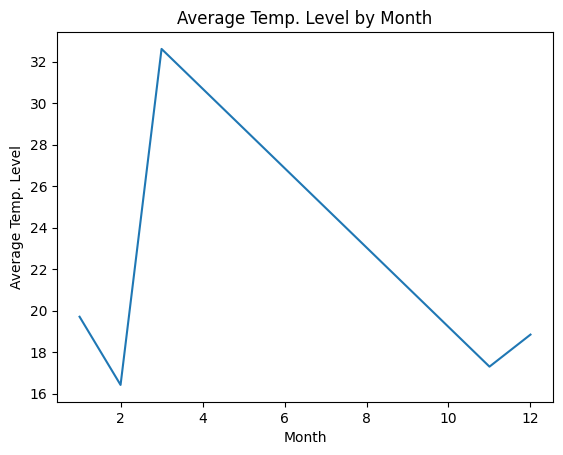

In [30]:
# Calculation of average Temperature by month
temp_level_by_month = df.groupby('month')['tempreature'].mean().plot()
temp_level_by_month.set_title('Average Temp. Level by Month')
temp_level_by_month.set_xlabel('Month')
temp_level_by_month.set_ylabel('Average Temp. Level')
plt.show()

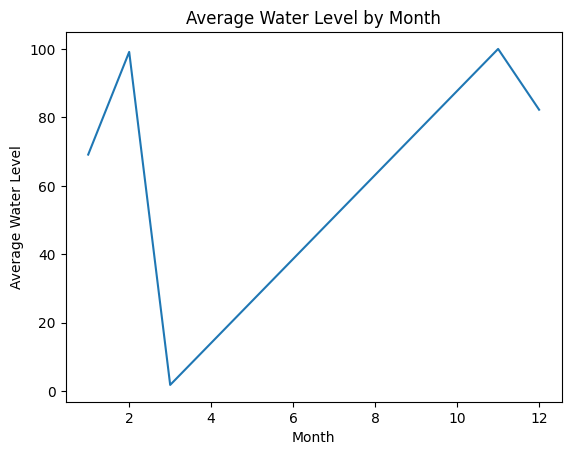

In [31]:

# Calculation of average water used by month
water_level_by_month = df.groupby('month')['water_level'].mean().plot()
water_level_by_month.set_title('Average Water Level by Month')
water_level_by_month.set_xlabel('Month')
water_level_by_month.set_ylabel('Average Water Level')
plt.show()

<Axes: xlabel='water_level', ylabel='Count'>

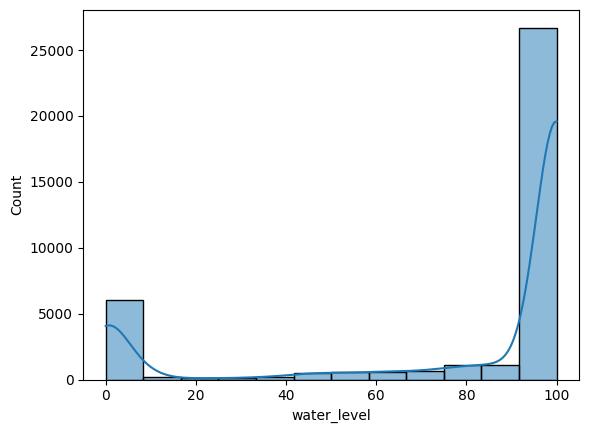

In [48]:
sns.histplot(data=df, x='water_level', bins=12, kde=True)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37920 entries, 0 to 37919
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     37920 non-null  datetime64[ns]
 1   tempreature              37920 non-null  int64         
 2   humidity                 37920 non-null  int64         
 3   water_level              37920 non-null  int64         
 4   N                        37920 non-null  int64         
 5   P                        37920 non-null  int64         
 6   K                        37920 non-null  int64         
 7   Fan_actuator_OFF         37920 non-null  float64       
 8   Fan_actuator_ON          37920 non-null  float64       
 9   Watering_plant_pump_OFF  37920 non-null  float64       
 10  Watering_plant_pump_ON   37920 non-null  float64       
 11  Water_pump_actuator_OFF  37920 non-null  float64       
 12  Water_pump_actuator_ON   37920 n

<Axes: title={'center': '12-Month Rolling Mean of Water Level'}, xlabel='Month', ylabel='Average Water Level'>

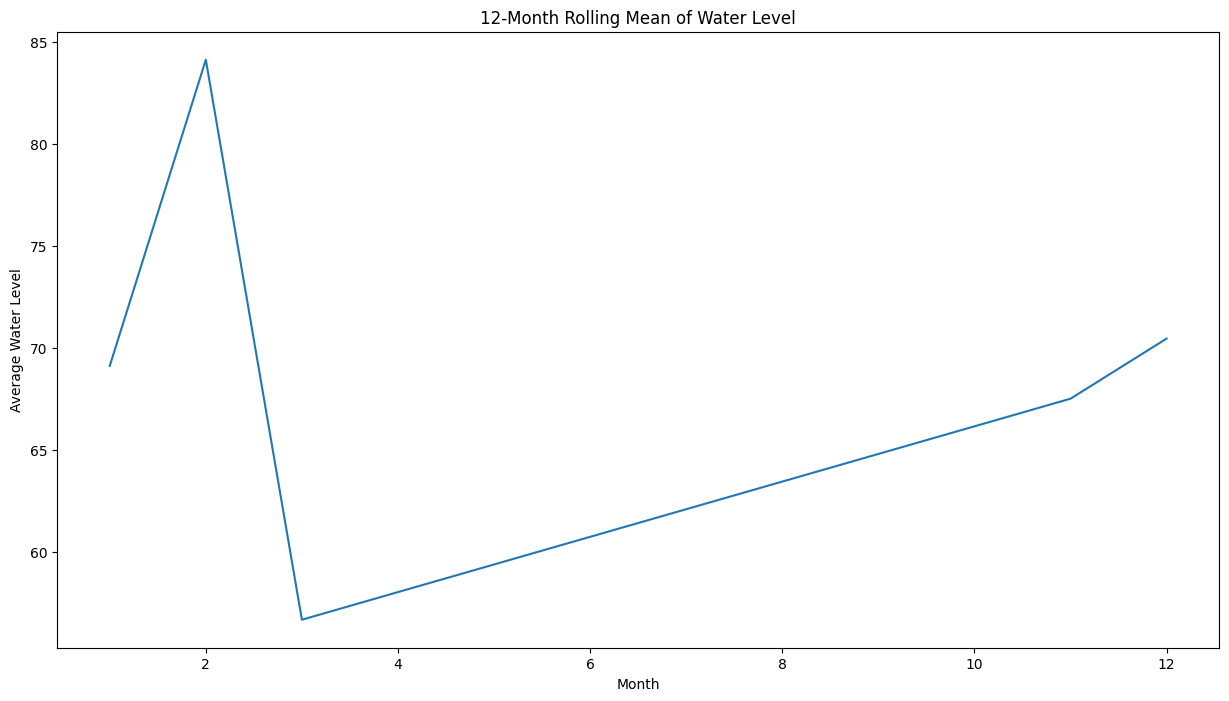

In [35]:
# Calculation of what months used the most water on average.
# Febuarary as shown below
df_grouped_month = df.groupby('month')['water_level'].mean()

df_grouped_month.rolling(12, min_periods=1).mean().plot(
    ylabel='Average Water Level',
    xlabel='Month',
    figsize=(15, 8),
    title='12-Month Rolling Mean of Water Level'
)

In [36]:
# scratch cell
# df = df_raw.copy()

df = df.dropna().reset_index(drop=True)

X = df.drop(['water_level','Fan_actuator_OFF', 'Fan_actuator_ON', 'Watering_plant_pump_OFF', 'Watering_plant_pump_ON', 'Water_pump_actuator_OFF', 'Water_pump_actuator_ON'], axis=1)
y = df['water_level']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [22]:
# # Train and Test split
# df = df.dropna().reset_index(drop=True)

# X = df.drop(['water_level'], axis=1)
# y = df['water_level']

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42)


In [37]:
# Drop the 'date' column as it's not directly usable by the RNN model
X_train_processed = X_train.drop('date', axis=1)
X_test_processed = X_test.drop('date', axis=1)

# Scale numerical features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

# Reshape data for LSTM input (samples, timesteps, features)
# For this template, we'll treat each observation as a single timestep.
timesteps = 1
num_features = X_train_scaled.shape[1]

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, num_features)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, num_features)

print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}")

X_train_reshaped shape: (30336, 1, 8)
X_test_reshaped shape: (7584, 1, 8)


In [42]:
model = keras.Sequential()
# Removed Embedding layer as it's not suitable for scaled numerical features.
# Add an LSTM layer with input_shape corresponding to our preprocessed data.
model.add(layers.LSTM(128, input_shape=(timesteps, num_features)))
model.add(Dropout(0.2)) # Added Dropout for regularization

# Add a Dense layer for regression (predicting a single continuous value: water_level).
model.add(layers.Dense(1)) # Output dimension is 1 for regression

# Compile the model with appropriate optimizer, loss function, and metrics for regression.
model.compile(optimizer='adam', loss='mse', metrics=['mae']) # Mean Squared Error (mse) and Mean Absolute Error (mae) for regression

model.summary()

print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,273 (274.50 KB)

 Trainable params: 70,273 (274.50 KB)

 Non-trainable params: 0 (0.00 B)

X_train_reshaped shape: (30336, 1, 8)
X_test_reshaped shape: (7584, 1, 8)


In [43]:
model.fit(X_train_reshaped, y_train, epochs=30, batch_size=32)

Epoch 1/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5891.8770 - mae: 69.5708
Epoch 2/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1425.8774 - mae: 33.3341
Epoch 3/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1131.7914 - mae: 26.6906
Epoch 4/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 934.7496 - mae: 23.3961
Epoch 5/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 765.8589 - mae: 20.7375
Epoch 6/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 649.1826 - mae: 18.8043
Epoch 7/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 577.1188 - mae: 17.4222
Epoch 8/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 544.0616 - mae: 16.5869
Epoch 9/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 500.5982 - mae: 15.8363
Epoch 10/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 467.0359 - mae: 15.1366
Epoch 11/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 446.4852 - mae: 14.5562
Epoch 12/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 431.4691 -

In [44]:
predictions = model.predict(X_test_reshaped)

# The 'predictions' variable will contain the model's output for each input sequence in X_test
print(predictions)

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[103.356384]
 [ 95.23637 ]
 [ 96.80104 ]
 ...
 [100.19463 ]
 [ 99.493866]
 [ 99.58394 ]]
